In [2]:
using IonSim
using QuantumOptics
using QuantumOptics: timeevolution, stochastic
import DifferentialEquations
import PyPlot
const plt = PyPlot
using Distributions
using Expectations

┌ Info: Precompiling Expectations [2fe49d83-0758-5602-8f54-1f90ad0d522b]
└ @ Base loading.jl:1317
┌ Warning: Module Compat with build ID 357924949960894 is missing from the cache.
│ This may mean Compat [34da2185-b29b-5c13-b0c7-acf172513d20] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Info: Skipping precompilation since __precompile__(false). Importing Expectations [2fe49d83-0758-5602-8f54-1f90ad0d522b].
└ @ Base loading.jl:1025
┌ Info: Precompiling FastGaussQuadrature [442a2c76-b920-505d-bb47-c5924d526838]
└ @ Base loading.jl:1317
┌ Warning: Module SpecialFunctions with build ID 357944086757838 is missing from the cache.
│ This may mean SpecialFunctions [276daf66-3868-5448-9aa4-cd146d93841b] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Info: Skipping precompilation since __precompile__(false). Importing FastGaussQuadrature [442a2c76-b920-505d-bb47-c5924d526838].
└ @ Base loading.

In [3]:
# set some plot configs
plt.matplotlib.rc("xtick", top=false)
plt.matplotlib.rc("ytick", right=false, left=false)
plt.matplotlib.rc("axes", labelsize=20, titlesize=20, grid=true)
plt.matplotlib.rc("axes", linewidth=2)
plt.matplotlib.rc("grid", alpha=0.25, linestyle="--")
plt.matplotlib.rc("font", family="Palatino", weight="medium")
plt.matplotlib.rc("figure", figsize=(8,4))
plt.matplotlib.rc("xtick.major", width=2)
plt.matplotlib.rc("ytick.major", width=2)

In [4]:
C = Ca40(["S-1/2", "D-1/2"])
L = Laser()
νa = 1.5e6  # axial trap frequency
νr = 3e6    # radial trap frequency
chain = LinearChain(
        ions=[C], com_frequencies=(x=νr,y=νr,z=νa), 
        vibrational_modes=(x=[], y=[], z=[1]))
T = Trap(configuration=chain, B=4e-4, Bhat=ẑ, δB=0, lasers=[L]);
L.k = (x̂ + ẑ)/√2 
L.ϵ = (x̂ - ẑ)/√2;
mode = T.configuration.vibrational_modes.z[1]

┌ Warning: !(ϵ ⟂ k)
└ @ IonSim /home/ion/.julia/packages/IonSim/5Hvou/src/lasers.jl:84


VibrationalMode(ν=1.5e6, axis=ẑ, N=10)

# RAP on RSB transition

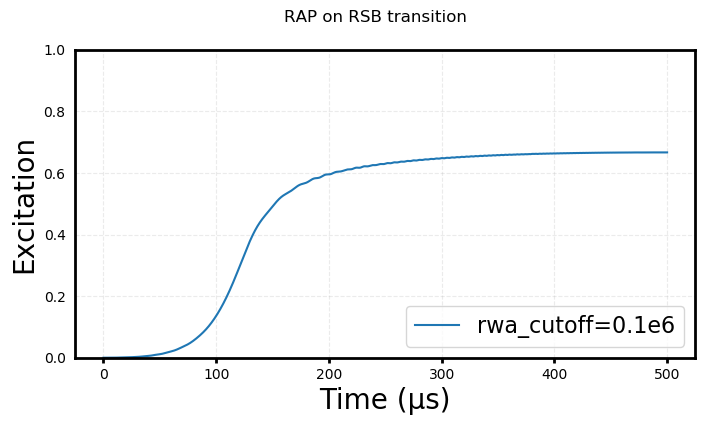

  0.316947 seconds (2.09 M allocations: 178.297 MiB, 10.01% gc time)


PyObject <matplotlib.legend.Legend object at 0x7f37dc7b4d50>

In [6]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

mode.N = 20
ψi_mode = thermalstate(mode, 2)

#ψi1 = dm(C["S-1/2"]) ⊗ dm(mode[2])
ψi1 = dm(C["S-1/2"]) ⊗ thermalstate(mode, 2)

δν = 300e3
Δϕ = 2π * (δν/2) * 1e-6
L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
# amplitude Rabi_freq
function Ω(t)
    if t < Tp
        return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
    else
        return 0
    end
end
L.E = Ω;
L.Δ  = Δf - mode.ν 

Tp = 500
tspan = 0:0.1:Tp
h = hamiltonian(T, rwa_cutoff=0.1e6)
@time tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi1, h)


ex1 = expect(ionprojector(T, "D-1/2"), ψt)
#plt.plot(tspan, ex1)
plt.plot(tout, ex1, label="rwa_cutoff=0.1e6")
#plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.ylabel("Excitation")
plt.xlabel("Time (μs)");
plt.suptitle("RAP on RSB transition")
plt.legend(loc="lower right", fontsize = 16)

# scaling with fock states |n>; sequence rsb RAP pulse followed by carrier pi pulse

In [7]:
n = one(C) ⊗ thermalstate(mode, 5)
ψi = dm(C["S-1/2"]) ⊗ dm(mode[5])
theoretical_nbar = expectation(n, ψi)

LoadError: MethodError: no method matching expectation(::Operator{CompositeBasis{Vector{Int64}, Tuple{Ca40, VibrationalMode}}, CompositeBasis{Vector{Int64}, Tuple{Ca40, VibrationalMode}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, ::Operator{CompositeBasis{Vector{Int64}, Tuple{Ca40, VibrationalMode}}, CompositeBasis{Vector{Int64}, Tuple{Ca40, VibrationalMode}}, Matrix{ComplexF64}})
[0mClosest candidates are:
[0m  expectation([91m::Distribution{Univariate, Continuous}[39m, ::Any) at /home/ion/.julia/packages/Expectations/KqWVw/src/iterable.jl:252
[0m  expectation([91m::Distribution{Univariate, Continuous}[39m, ::Any, [91m::Type{var"#s47"} where var"#s47"<:ExplicitQuadratureAlgorithm[39m; kwargs...) at /home/ion/.julia/packages/Expectations/KqWVw/src/iterable.jl:252

In [10]:
one(C)

Operator(dim=2x2)
  basis: ⁴⁰Ca

 1.0+0.0im      ⋅    
     ⋅      1.0+0.0im

In [11]:
T.B = 4e-4
Δf = transition_frequency(T, 1, ("S-1/2", "D-1/2"))
E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))

mode.N = 20
ψi = dm(C["S-1/2"]) ⊗ dm(mode[5])
theoretical_nbar = expectation(n, ψi)
i = 0

while true
    # # simulation with RAP pulse on rsb transition
    δν = 300e3
    Δϕ = 2π * (δν/2) * 1e-6
    L.ϕ = t -> (-Δϕ + (2Δϕ / Tp) * t) * t;
    # amplitude Rabi_freq
    function Ω(t)
        if t < Tp
            return 5*E1*sin(π*t/Tp) #E*sin(π*t/Tp) #exp(-(t-Tp/2)^2/2500) ; sin(2π * t / 16)^2
        else
            return 0
        end
    end
    L.E = Ω;
    L.Δ  = Δf - mode.ν 

    Tp = 500
    tspan = 0:0.1:Tp
    h = hamiltonian(T, rwa_cutoff=0.1e6)
    @time tout, ψt = timeevolution.schroedinger_dynamic(tspan, ψi, h)
    
    ψo = ψt[end]
    
    p = expect(ionprojector(T, "S-1/2"), ψo)
    if Bernoulli(p) == 1
        break
    
    # simulation with pi pulse on carrier
        L.Δ = Δf
        E1 = Efield_from_pi_time(3e-6, T, 1, 1, ("S-1/2", "D-1/2"))
        L.E = E1
        L.ϕ = 0

        tpi = 3 # length of pi pulse


        tlist = 0:0.1:tpi
        h = hamiltonian(T, rwa_cutoff=1e5)
        @time tout, ψt = timeevolution.schroedinger_dynamic(tlist, ψo, h)

        ψi = ψo
        i += 1
    end
end
phonon_number_measurement = i
error = abs(theoretical_nbar - phonon_number_measurement) / theoretical_nbar

LoadError: MethodError: no method matching expectation(::Operator{CompositeBasis{Vector{Int64}, Tuple{Ca40, VibrationalMode}}, CompositeBasis{Vector{Int64}, Tuple{Ca40, VibrationalMode}}, SparseArrays.SparseMatrixCSC{ComplexF64, Int64}}, ::Operator{CompositeBasis{Vector{Int64}, Tuple{Ca40, VibrationalMode}}, CompositeBasis{Vector{Int64}, Tuple{Ca40, VibrationalMode}}, Matrix{ComplexF64}})
[0mClosest candidates are:
[0m  expectation([91m::Distribution{Univariate, Continuous}[39m, ::Any) at /home/ion/.julia/packages/Expectations/KqWVw/src/iterable.jl:252
[0m  expectation([91m::Distribution{Univariate, Continuous}[39m, ::Any, [91m::Type{var"#s47"} where var"#s47"<:ExplicitQuadratureAlgorithm[39m; kwargs...) at /home/ion/.julia/packages/Expectations/KqWVw/src/iterable.jl:252